# How to generate histograms using Trino and Presto

This provides and example of how to generate frequency histograms using Trino and Presto.
Disambiguation: we refer here to computing histograms of table data, rather than histograms of the columns statistics used by the cost based optimizer.

Author and contacts: Luca.Canali@cern.ch

## Setup and prerequisites

This is how you can setup a trino instance for testing using a docker image  
See also https://hub.docker.com/r/trinodb/trino

`docker run -p 8080:8080 --name trino trinodb/trino`


In [ ]:
# Connect to trino using the Python library
# See also https://github.com/trinodb/trino-python-client
!pip install trino

## Create the test table

In [2]:
import trino.dbapi

# Connect to an existing database and create the test table
with trino.dbapi.connect(host="localhost", port=8080, user="system", catalog="memory", schema="default") as trino_conn:
    cur = trino_conn.cursor()

    # use this drop statement if you need to recreate the table
    # cur.execute("DROP TABLE data")
    # cur.fetchone()
    
    cur.execute("CREATE TABLE data as select random()*100 random_value from unnest(sequence(1,100))")
    cur.fetchone()

## Define the query to compute the histogram

In [3]:
table_name = "data" # table or temporary view containing the data
value_col = "random_value" # column name on which to compute the histogram
min = -20  # min: minimum value in the histogram
max = 90   # maximum value in the histogram
bins = 11  # number of histogram buckets to compute
step = (max - min) / bins
        
query = f"""
with bucketized as (
  select width_bucket({value_col}, {min}, {max}, {bins}) as bucket
  from {table_name}
),
hist as (
  select bucket, count(*) as cnt
  from bucketized
  group by bucket
),
buckets as (
  select id as bucket from unnest(sequence(1,{bins})) as t(id)
)
select
    bucket, {min} + (bucket - 0.5) * {step} as value,
    coalesce(cnt, 0) as count
from hist right outer join buckets using(bucket)
order by bucket
"""
    

## Fetch the histogram data into a pandas dataframe

In [ ]:
import pandas as pd
import trino.dbapi

# query Trino and put the result into a pandas Dataframe
with trino.dbapi.connect(host="localhost", port=8080, user="system", catalog="memory", schema="default") as trino_conn:
    hist_pandasDF = pd.read_sql(query, con=trino_conn)  

# Decription
#
# bucket: the bucket number, range from 1 to bins (included)
# value: midpoint value of the given bucket
# count: number of values in the bucket    
            
# additional conversion to numeric, as I noticed that some values were fetched as strings
hist_pandasDF = hist_pandasDF.apply(pd.to_numeric)
hist_pandasDF

In [5]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["frequency"] = hist_pandasDF["count"] / sum(hist_pandasDF["count"]) 
              
hist_pandasDF

,bucket,value,count,frequency
0,1,-15.0,0,0.000000
1,2,-5.0,0,0.000000
2,3,5.0,8,0.090909
3,4,15.0,6,0.068182
4,5,25.0,10,0.113636
5,6,35.0,7,0.079545
6,7,45.0,10,0.113636
7,8,55.0,15,0.170455
8,9,65.0,7,0.079545
9,10,75.0,16,0.181818


## Histogram plotting

The first plot is a histogram with the event counts (number of events per bin).
The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).


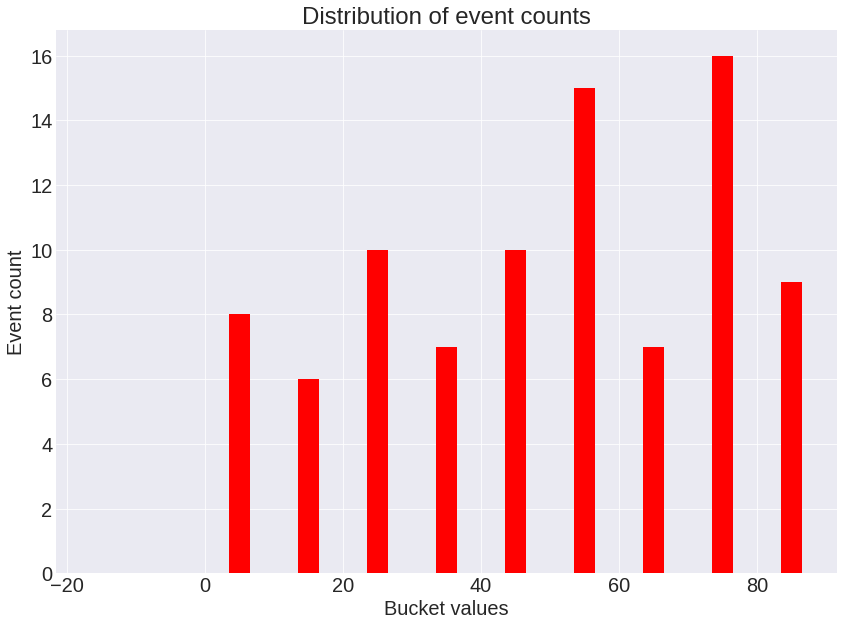

In [6]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["count"]

# bar plot
ax.bar(x, y, width = 3.0, color='red', )

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()


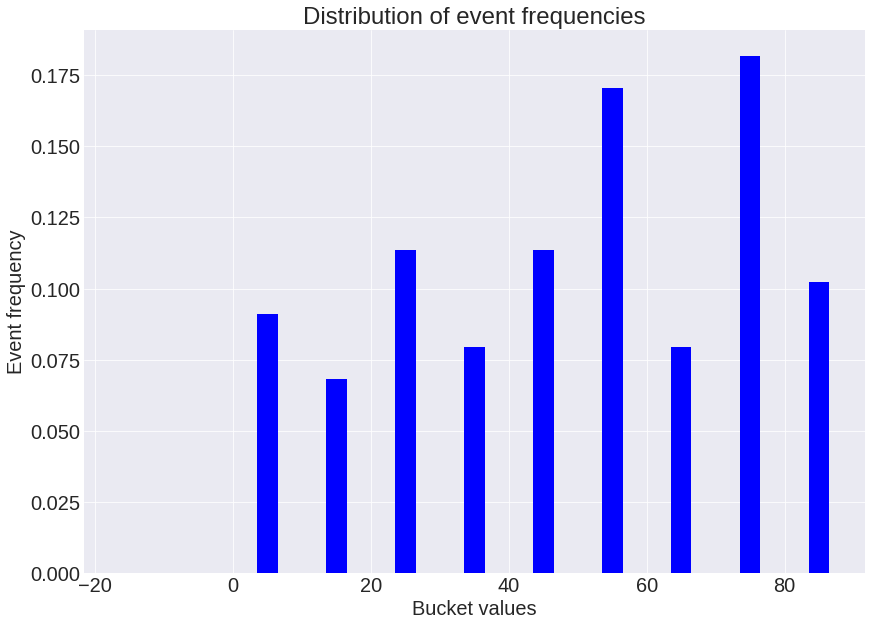

In [7]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["value"]
y = hist_pandasDF["frequency"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()
